In [1]:


from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')




# Training and Applying a CIFAR classifier

In this project we are going to develop a CIFAR classifier.

To do so we will use Python and Keras, a high-level neural network API, which is written in Python and capable of running on top of either TensortFlow, Theano or CNTK.

Hence, first of all we will load all the required libraries:


In [2]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, merge, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from sklearn.metrics import log_loss

Using TensorFlow backend.




After having loaded all the modules needed to implement the classifier, we will proceed to define some values, which will be used as parameters for our model.

Hence we will define the batch size, i.e. the number of that that are going to be propagated through the network, to 32. Also we will also specify the number of epochs, i.e. we will train our model with 'epochs' full training cycles.

Furthermore, we will define wheter we are willing to perform data augmentation. And we will define that our data will count with 10 classes (number of classes in the dataset), this will be used to define our data as categorical.

All what we said, can be said defined in the code below:


In [3]:

batch_size = 32
num_classes = 10
epochs = 3
data_augmentation = False



Once we have already defined the parameters that we are going to use, we will proceed to divide our data on test and training sets.

In order to do so, we will shuffle and split the data, this is done in the code below:


In [4]:
# The data, shuffled and split between train and test sets:
# Load Cifar10 data. Please implement your own load_data() module for your own dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


And we will proceed to define our data as categorical, specifying that our data will have 10 classes, as we previously defined.

In [5]:

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)



Now, that we have already divided our data on train and test set, we will proceed to generate our model.

To do so we will proceed to generate a model with 2 2D Convolutional layers, in which we will define the dimensionality of the outpit space as 32 and the kernel size as 3 x 3. Additionally we will define a ReLu activation, since it produces sparsity and reduced likelihood of vanishing gradient.

Furthermore, between those 2 layers we will perform regularization by performing a Dropout with a rate equal to 0.2, to prevent complex co-adaptations on the training data.

And after the second layer we will perform max pooling, in order to reduce the dimensionality of the output of this second layer followed by a flatten process to reduce our input to a 15-d vector to then use a Dense layer with 512 units, a fully connected neural network layer where each input node is connected to each output node.

Finally we apply reguralization again via Dropout, this time with a rate equal to 0.5, and then we apply again a dense layer with 10 units and softmax activation.

All of this is done in the code below:


In [6]:
def simple_model(x_train, num_classes):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model

In [7]:
from keras.applications import vgg16
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
def vgg16_model(img_rows, img_cols, channel=1, num_classes=None):


    # create the base pre-trained model
    # base_model = InceptionV3(weights='imagenet', include_top=False)
    base_model = vgg16.VGG16(weights='imagenet', include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(128, activation='relu')(x)
    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(num_classes, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False

    # Learning rate is changed to 0.001
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])


    return model, base_model

In [ ]:

    # Create model
    #model = Model(img_input, x)

In [8]:

model, base_model = vgg16_model(x_train.shape[1], x_train.shape[2], 3, num_classes)
# model = simple_model(x_train, num_classes)




After having specified the layers on our model, we are going to select a gradient descent optimization algorithm to find an approapiate local optimum.

The selected optimization algorithms in our case will be a RMSprop with a learning rate equal to 0.0001 and a decay equal to 1e-6 and SGD with a learning rate 0.01, a momentum equal to 0.9, a decay equal to the divison between its learning rate and the number of epochs that we defined previously.


In [9]:
# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)



Since now we have divided our data into train and test sets, and also we have specified the layers of our model and defined two optmization algorithms RMSprop and SGD. Now we will proceed to train our model. To do so, we will use the categorical crossentropy as our loss function and the sgd optimizer, that we previously defined. Furthermore, we will take accuracy as our main metric.


In [10]:
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    # Start training (or finetuning)
    hist = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        epochs=epochs,
                        validation_data=(x_test, y_test))

Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 197s - loss: 1.7313 - acc: 0.4160 - val_loss: 1.5055 - val_acc: 0.4879
Epoch 2/3
50000/50000 [==============================] - 195s - loss: 1.4174 - acc: 0.5153 - val_loss: 1.3844 - val_acc: 0.5250
Epoch 3/3
50000/50000 [==============================] - 194s - loss: 1.3320 - acc: 0.5426 - val_loss: 1.3339 - val_acc: 0.5375


In [11]:

# Make predictions
predictions_valid = model.predict(x_test, batch_size=batch_size, verbose=1)

# Cross-entropy loss score
score = log_loss(y_test, predictions_valid)
print(score)


10000/10000 [==============================] - 29s    
1.24423578936


In [142]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)



0 input_8
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [11]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:16]:
   layer.trainable = False
for layer in model.layers[16:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers

In [13]:
# And now train again
print('Not using data augmentation.')
# Start training (or finetuning)
hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)

Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 196s - loss: 0.9625 - acc: 0.6644 - val_loss: 0.9712 - val_acc: 0.6589


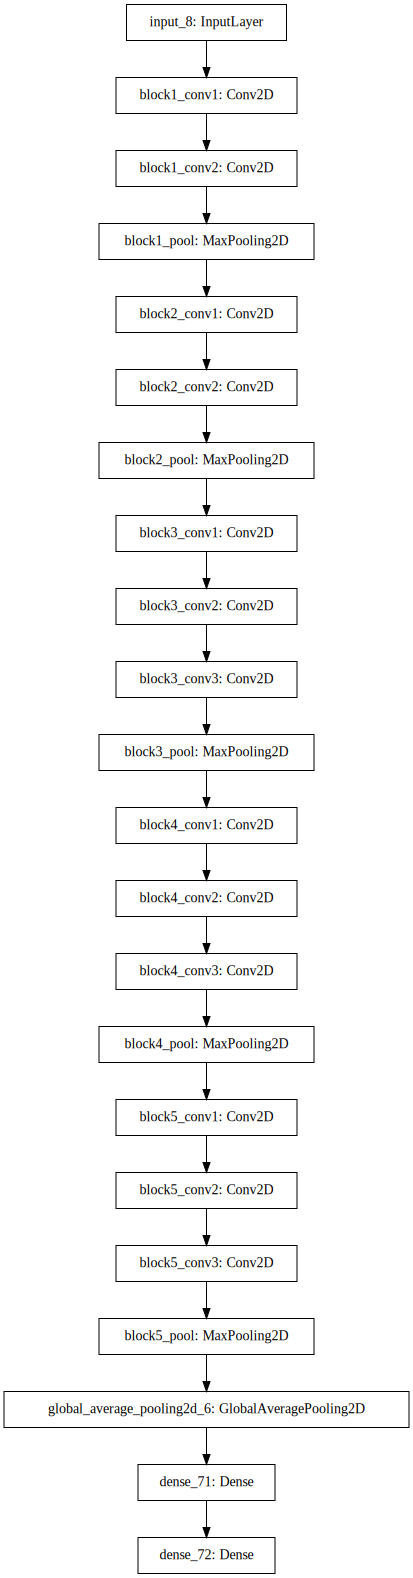

In [145]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

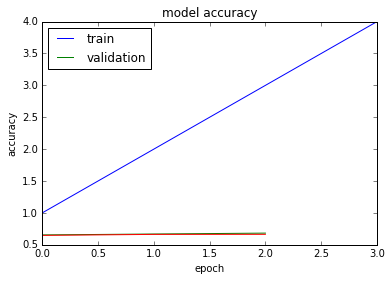

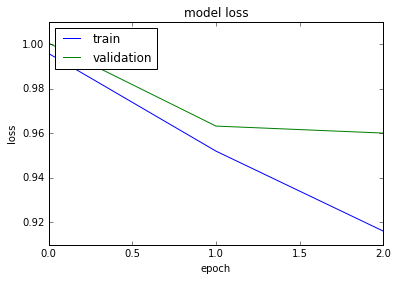

In [151]:
%matplotlib inline
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
# list all data in history
#print(hist.history)
#print(hist.history.keys())
#  "Accuracy"
plt.plot([1,2, 3, 4])
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

t-sne visualization

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

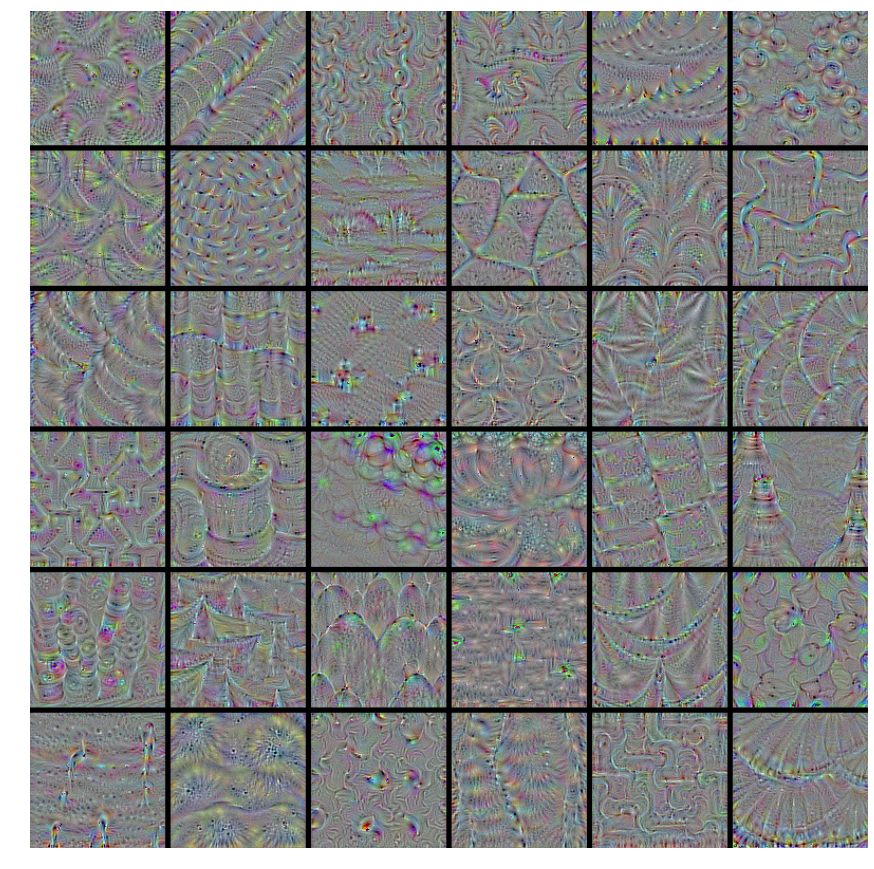

In [23]:
'''Visualization of the filters of VGG16, via gradient ascent in input space.
This script can run on CPU in a few minutes (with the TensorFlow backend).
Results example: http://i.imgur.com/4nj4KjN.jpg
'''
%matplotlib inline
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from __future__ import print_function

from scipy.misc import imsave
import numpy as np
import time
from keras.applications import vgg16
from keras import backend as K

# dimensions of the generated pictures for each filter.
img_width = 128
img_height = 128

# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
layer_name = 'block5_conv1'

# util function to convert a tensor into a valid image


def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# build the VGG16 network with ImageNet weights
# model = vgg16.VGG16(weights='imagenet', include_top=False)
# print('Model loaded.')

model.summary()

# this is the placeholder for the input images
input_img = model.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)


kept_filters = []
for filter_index in range(0, 150):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        #print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

# we will stich the best 64 filters on a 8 x 8 grid.
n = 6

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

# save the result to disk
fig =plt.figure(figsize=(15, 15), dpi= 80, facecolor='w', edgecolor='k')
img = plt.imshow(stitched_filters)
img.set_cmap('hot')
plt.axis('off')
plt.show()